In [1]:
%matplotlib notebook
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pdb
from config import Config
import utils
import model as modellib
import visualize
from model import log
import coco
import pandas as pd
import json
from sklearn.cross_validation import train_test_split
from PIL import Image
import skimage.io



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#get_ipython().run_line_magic('matplotlib', 'inline')

# Root directory of the project
ROOT_DIR = os.getcwd()
timestr = time.strftime("%Y%m%d-%H%M%S")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

imgs_loc = ROOT_DIR + '/few_imgs_and_tags/all_images/all_imgs/'#'/normalized/' #sys.argv[1] # where the training images are located
#tags_info = ROOT_DIR  + '/scavenging/scavenging.csv' #sys.argv[2] # where the csv file that containes tags are located
tags_info = ROOT_DIR + '/mummification_not_normalized_orig.csv' #'/mummification_normalized512by512.csv'
layers = '3+' #sys.argv[3] # what layers you want to train. options are: all, heads, 3+, 4+ and 5+
ep = '50' # sys.argv[4] # the number of epochs
lr = '0.002' #sys.argv[5]

SIZE = '512' #sys.argv[6] #128

parametrs = imgs_loc + '\n' + tags_info + '\n' + layers + '\n'+ ep + '\n' + lr + '\n' + SIZE
print(parametrs)

ep = int(ep)
SIZE = int(SIZE)

## All other photos for other years are in the public directory
## A file named tags1.csv in /home/wyan3/origin has all the tags for all of the photos for all years


# ## Configurations


class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "corpse"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    LEARNING_RATE = float(lr) #0.02

    # Number of classes (including background)
    ##used this to get the number of unique classes
    ##df = pd.read_csv('/home/wyan3/original/tags1.csv'),  df['tag'].unique().shape[0], 
    ## The answer was 298
    NUM_CLASSES = 2 

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = SIZE #448 #832
    IMAGE_MAX_DIM = SIZE #704 #1216
    
    TRAIN_ROIS_PER_IMAGE = 32

    # Use smaller anchors because our image and objects are small
    ##RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    ## I comment this out because it seems the one defines in the config class is more generic

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    ##TRAIN_ROIS_PER_IMAGE = 32  ## RoiAlign - Realigning RoIPool to be More Accurate

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    ## comments with 2 # are Sara's
    
config = ShapesConfig()
#config.display()


# ## Notebook Preferences

# In[19]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.all_sub_imgsplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


# ## Dataset
# 
# Create a synthetic dataset
# 
# Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:
# 
# * load_image()
# * load_mask()
# * image_reference()

# In[20]:
def split_data(csv_file):
    df = pd.read_csv(csv_file)
    train,test = train_test_split(df, test_size = 0.3)
    train = train.reset_index(drop = True)
    test = test.reset_index(drop = True)
   # train.to_csv(ROOT_DIR + '/scavenging/train_data_scavenging_' + timestr + '.csv')
    #test.to_csv(ROOT_DIR + '/scavenging/val_data_scavenging_' + timestr + '.csv')
    return train, test

class ForensicDataset(utils.Dataset):
    def __init__(self, data, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        #self.class_info = [{"source": "", "id": 0, "name": "BG"}] ##Not sure if I need to keep this
        self.class_info = []
        self.add_class("forensics", 0, 'BG')
        self.add_class("forensics", 1, 'mummification')
        #self.add_class("forensics", 2, 'mold')
        #self.add_class("forensics", 3, 'purge')
        self.source_class_ids = {}
        self.data = data

    def load_sub_images(self):
        df = self.data 
        num_unique_tags = df.tag.unique().shape[0]
        #print(num_unique_tags)

        imgs = [] # a list of images in which we have the taged images and their locations
        num = 0
        image_dir = imgs_loc
        for i in range(df['image1'].unique().shape[0]):
            all_sub_imgs = df.loc[df['image1'] == df['image1'].unique()[i]]
            all_sub_imgs = all_sub_imgs.reset_index(drop = True)
            images_dir = image_dir + df['image1'].unique()[i]

            if os.path.isfile(images_dir):
                im = skimage.io.imread(images_dir)
                im, window, scale, padding = utils.resize_image(im,
                        min_dim=config.IMAGE_MIN_DIM,
                        max_dim=config.IMAGE_MAX_DIM,
                        padding=config.IMAGE_PADDING)
                #skimage.io.imsave('resized.png', im)
                '''
                it returns:
                image: the resized image
                window: (y1, x1, y2, x2). If max_dim is provided, padding might
                be inserted in the returned image. If so, this window is the
                coordinates of the image part of the full image (excluding
                the padding). The x2, y2 pixels are not included.
                scale: The scale factor used to resize the image
                padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
                '''

                hei, wi = im.shape[:2] #im.se
                window_w = window[3] - window[1]
                window_h = window[2] - window[0]
                num += 1
                for j in range(all_sub_imgs.shape[0]):
                    sub_info = all_sub_imgs['location'][j]
                    sub_info = json.loads(sub_info)[0]
                    geometry = sub_info['geometry']

                    x = int(float(geometry['x']) * window_w + padding[1][0]) #padding[1][0] is what's padded to the left
                    y = int(float(geometry['y']) * window_h + padding[0][0]) #padding[0][0] is what's added to the top
                    w = int(float(geometry['width']) * window_w)
                    h = int(float(geometry['height']) * window_h)

                    sub_info = (x, y, w, h)
                    imgs.append((all_sub_imgs['tag'][j], sub_info))

                self.add_image("forensics", image_id = i, path = images_dir,width = wi, height= hei, images = imgs)
            image_dir = imgs_loc
            imgs = []
            #print(self.image_info)
            #break


    #this method is going to load/read the image(that includes the sub_imges)
    #Haven't done anything with dtype. I might need to change it to uint8
    def load_image(self, image_id):
        #print(self.image_info[image_id]["path"])
        path = self.image_info[image_id]["path"]
        tag = self.image_info[image_id]["images"] 
        #print("id : ", image_id, " tag: ", tag, " path: ", path)
        image = cv2.imread(path,1) #1 loads a color image
        return image
        '''
        if tag[0][0] == 'fly':
            img_array = np.zeros((128, 128, 3))
        elif tag[0][0] == 'larvae':
            img_array = np.ones((128, 128, 3))
        return img_array
        '''
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #print(info)
        shapes = info['images']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, dims) in enumerate(info['images']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)

        mask_temp = mask.copy()
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            if (mask[:, :, i] * occlusion).any():
                mask[:, :, i] = mask[:, :, i] * occlusion
                occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        if mask[:, :, 0].sum() == 0:
            import bpython
            bpython.embed(locals())
        if mask.sum() == 0:
            print("The mask was all zeros")
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color): 
        """Draws a shape from the given specs."""
        x, y, w, h = dims
        cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, -1)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        #print(info)
        if info["source"] == "forensics":
            return info["images"]
        else:
            super(self.__class__).image_reference(self, image_id)

/home/mousavi/few_imgs_and_tags/all_images/all_imgs/
/home/mousavi/mummification_not_normalized_orig.csv
3+
50
0.002
512


In [3]:
########################################################
###################### MAIN ############################
########################################################

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#normalized
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180723T1823/mask_rcnn_corpse_0020.h5' #mummification with 0.15 acc
#un-normalized
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180724T1820/mask_rcnn_corpse_0014.h5' 
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180807T0053/mask_rcnn_corpse_0054.h5' # mAP:  0.367577413832
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180807T1747/mask_rcnn_corpse_0011.h5' # mAP:  0.2525748557
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180807T2006/mask_rcnn_corpse_0011.h5' #mAP:  0.137420576815
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180808T2047/mask_rcnn_corpse_0484.h5' # mAP:  0.315860215294
#model_path = '/home/mousavi/Mask_RCNN_Sara/logs/corpse20180809T0303/mask_rcnn_corpse_0099.h5' #mAP:  0.344945355517
#model_path = '/home/mousavi/logs/corpse20180812T0445/mask_rcnn_corpse_0491.h5' #mAP:  0.378378379184
model_path = '/home/mousavi/logs/corpse20180814T0316/mask_rcnn_corpse_0488.h5'#mAP:  0.295045045582

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.898637 to fit

Loading weights from  /home/mousavi/logs/corpse20180814T0316/mask_rcnn_corpse_0488.h5


In [4]:
train = pd.read_csv(os.path.join(ROOT_DIR,"mumm.train.data.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR,"mumm.val.data.csv"))
#print(tags_info)
#train, test = split_data(tags_info)
#print(test)
# Training dataset
dataset_train = ForensicDataset(train)
print(train.shape)
dataset_train.load_sub_images()


dataset_train.prepare()
#image_ids = np.random.choice(dataset_train.image_ids, 4)
# Validation dataset
dataset_val = ForensicDataset(test)
dataset_val.load_sub_images()
dataset_val.prepare()
print(test.shape)

print(dataset_train.image_ids)

(191, 9)
(80, 9)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137]


In [7]:
#Testing how the results are in trained data
'''
image_ids = dataset_train.image_ids

APs = []
for image_id in image_ids:
    
    image_not_resized = dataset_train.load_image(image_id)
    
    mask, class_ids = dataset_train.load_mask(image_id)
    image_name = dataset_train.image_info[image_id]['path']
'''

    
import glob
import skimage.io
import csv

predicteds = []
found = 0

for image_name in glob.glob((ROOT_DIR + '/random_untagged_images/imgs/*.JPG')):
    image_not_resized = skimage.io.imread(image_name)
    width = image_not_resized.shape[1]
    height = image_not_resized.shape[0]
    image_name = image_name[image_name.find("UT"):]

    
    ##image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_train, inference_config,
    ##                           image_id, use_mini_mask=False)

    ##visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
    ##                            dataset_train.class_names,figsize=(8, 8))
    

    results = model.detect([image_not_resized], verbose=0)

    r = results[0]
    ##AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id,
    ##                     r["rois"], r["class_ids"], r["scores"])
    ##APs.append(AP)
    if len(r['rois']) > 0:
        for i in range(len(r['rois'])):
            pred = []
            pred.append(image_name)
            loc = []
            loc.append('x: ' + str(r['rois'][i][1]/width))
            loc.append('y: ' + str(r['rois'][i][0]/height))
            loc.append('width: ' + str((r['rois'][i][3]- r['rois'][i][1]) /width))
            loc.append('height: ' + str((r['rois'][i][2]- r['rois'][i][0]) /height))
            pred.append(loc)
            pred.append(dataset_train.class_names[r['class_ids'][0]])
            pred.append(r['scores'][i])
            predicteds.append(pred)
        #print(image_name ,",", r['rois'],",", dataset_train.class_names[r['class_ids'][0]],",", r['scores'] )
        #visualize.display_instances(image_not_resized, r['rois'], r['masks'], r['class_ids'], 
        #                       dataset_train.class_names, r['scores'],figsize=(8, 8))#, ax=get_ax())
        found += 1
        if found == 150:
           break
#print(predicteds) 

with open("predicted_mummification.csv", 'w')as output:
    writer = csv.writer(output, lineterminator = "\n")
    writer.writerows(predicteds)

##print("mAP: ", np.mean(APs))

/home/mousavi/utils.py:74: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union
/home/mousavi/utils.py:163: RuntimeWarning: invalid value encountered in greater
  remove_ixs = np.where(iou > threshold)[0] + 1


In [31]:
print(r['rois'][1])
print(r['rois'][1][0])
print(r['rois'][1][1])
print(r['rois'][1][2])
print(r['rois'][1][3])

[1886 2714 3185 4283]
1886
2714
3185
4283


In [6]:
predicteds

[['UT01-15D_02_06_2016(40).JPG',
  ['x: 0.2987012987012987',
   'y: 0.45098039215686275',
   'width: 0.21286525974025974',
   'height: 0.20649509803921567'],
  'mummification',
  0.89611155],
 ['UT01-15D_03_19_2016(30).JPG',
  ['x: 0.7987012987012987',
   'y: 0.7104779411764706',
   'width: 0.19338474025974026',
   'height: 0.2506127450980392'],
  'mummification',
  0.9871043],
 ['UT01-15D_03_19_2016(30).JPG',
  ['x: 0.5507305194805194',
   'y: 0.5778186274509803',
   'width: 0.3183847402597403',
   'height: 0.39797794117647056'],
  'mummification',
  0.9185135],
 ['UT01-15D_03_19_2016(30).JPG',
  ['x: 0.734375',
   'y: 0.3538602941176471',
   'width: 0.13859577922077923',
   'height: 0.2270220588235294'],
  'mummification',
  0.7053153]]

/home/mousavi/Mask_RCNN_Sara/all_images/random_untagged_images_orig_size/*.JPG
/home/mousavi/Mask_RCNN_Sara/normalized/UT08-15D_03_30_2015(65).JPG
UT08-15D_03_30_2015(65).JPG , [[ 64 143 316 393]
 [136 108 208 163]
 [159 261 348 346]] , mummification , [0.8155205  0.76253223 0.7038613 ]


<IPython.core.display.Javascript object>


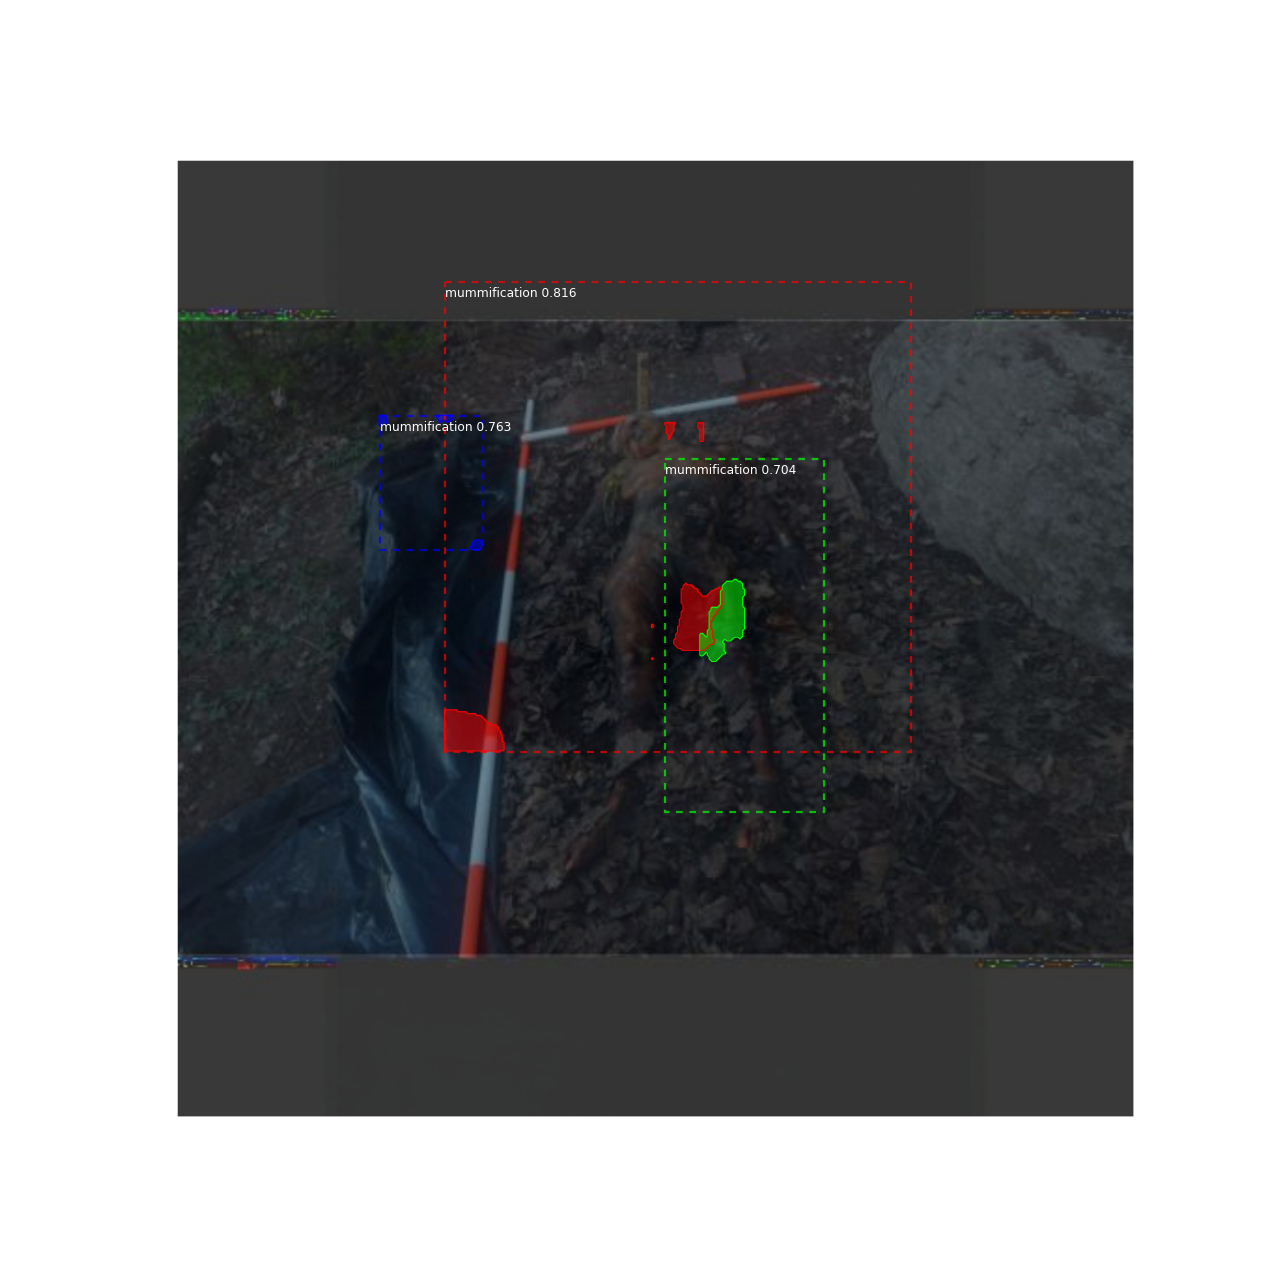

/home/mousavi/Mask_RCNN_Sara/normalized/UT02-15D_04_14_2015(24).JPG
UT02-15D_04_14_2015(24).JPG , [[184  91 379 396]
 [128  20 224 156]] , mummification , [0.8884475  0.76153845]


<IPython.core.display.Javascript object>


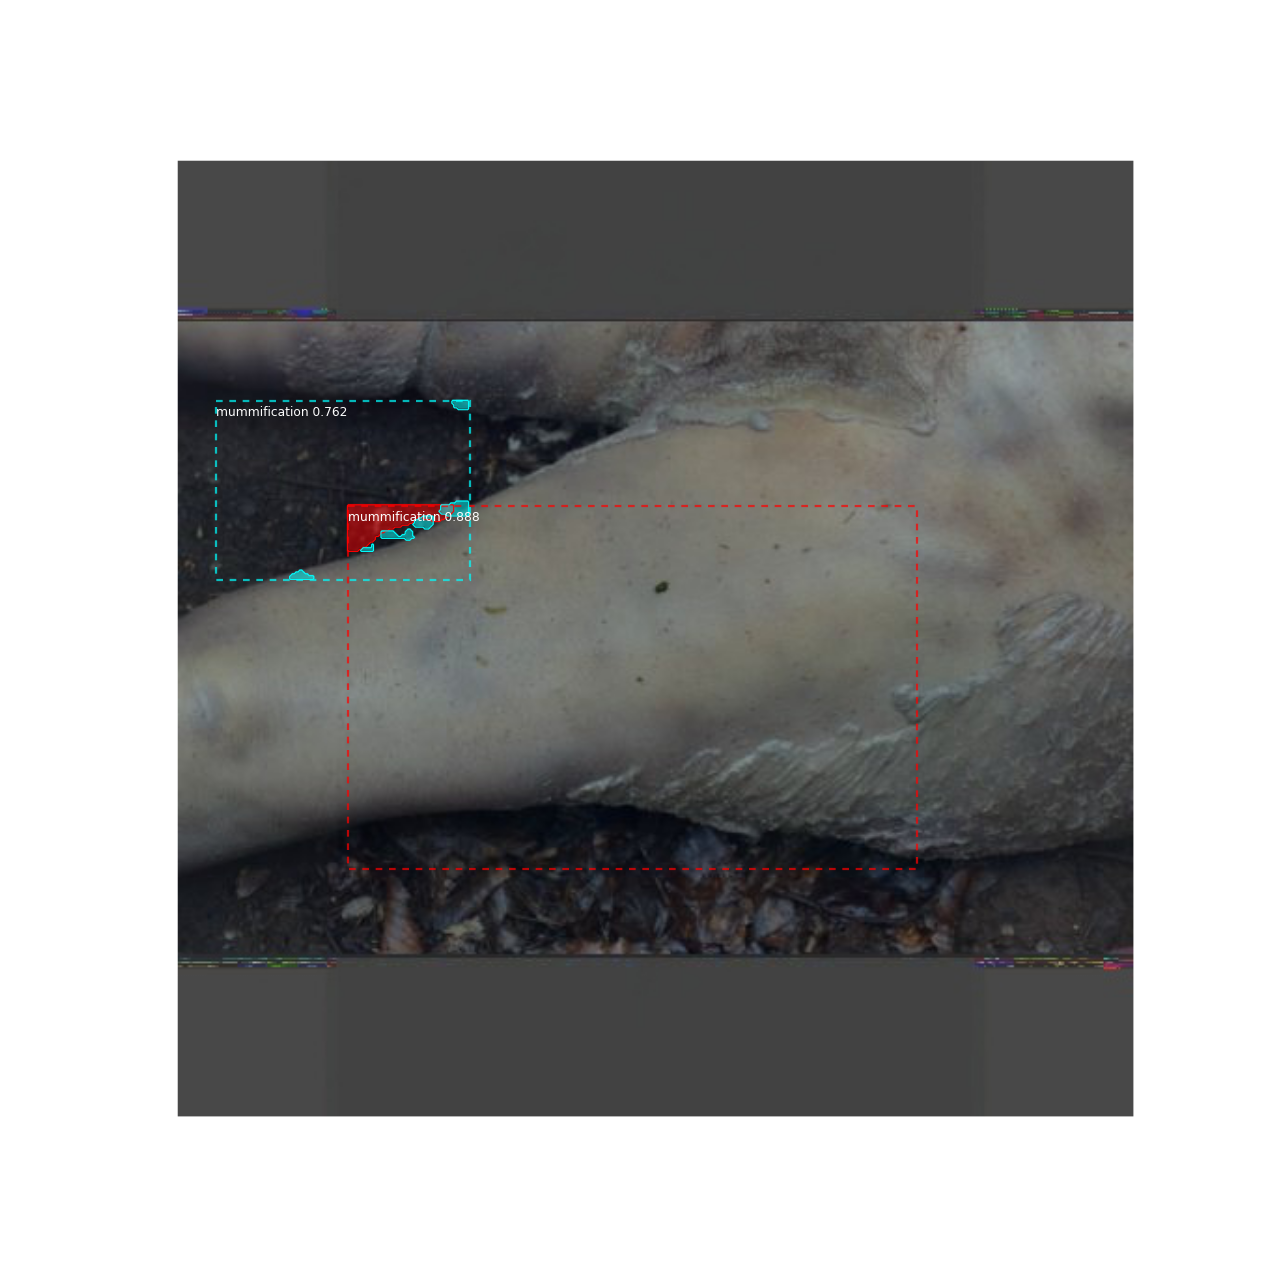

In [6]:
import csv
import os
import skimage.io
import random
import pandas as pd
import glob
import timeit
t = 0

flag = False
found = 0
print(ROOT_DIR + '/all_images/random_untagged_images_orig_size/*.JPG')
for image_name in glob.glob((ROOT_DIR + '/normalized/*.JPG')):#'/all_images/random_untagged_images_orig_size/*.JPG')):
    print(image_name)
    image = skimage.io.imread(image_name)
    image, window, scale, padding = utils.resize_image(
        image, min_dim=config.IMAGE_MIN_DIM,max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    #print(image_name)
    image_name = image_name[image_name.find("UT"):]
    #print(image_name)

    results = model.detect([image], verbose=1)
  

    
    r = results[0]
    if len(r['rois']) > 0:
        print(image_name ,",", r['rois'],",", dataset_val.class_names[r['class_ids'][0]],",", r['scores'] )
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'])#,figsize=(8, 8))#, ax=get_ax())
        found += 1
        if found == 2:
            break
        
#boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates